# Machine Learning Supervisado para Regresión: Guía Práctica Completa

En este notebook aprenderás a:

### Preparar datasets para regresión:
- División correcta train/test
- Validación cruzada (K-Fold)
- Escalado: StandardScaler, MinMax, RobustScaler

### Entrenar modelos clásicos de regresión:
- Regresión Lineal
- Ridge y Lasso
- kNN Regressor
- SVR (Support Vector Regression)
- Random Forest Regressor
- Gradient Boosting Regressor

### Métricas de evaluación:
- MSE (Mean Squared Error)
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² (coeficiente de determinación)
- Error relativo (%)  
- Visualización de errores y predicciones

### Optimización de hiperparámetros:
- GridSearchCV
- RandomizedSearchCV
- Halving Grid Search

### Interpretación del modelo:
- Importancia de features (RF y GB)
- Coeficientes (Lineal / Ridge / Lasso)
- Curvas de predicción vs reales

### Uso del modelo entrenado para predecir nuevos datos

Notebook 100% educativo con buenas prácticas profesionales.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    cross_val_score,
    GridSearchCV, 
    RandomizedSearchCV
)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)


## 1. Dataset

Usaremos **California Housing**, un dataset clásico para regresión:
- 20,640 muestras
- 8 features numéricas
- Variable objetivo: precio medio de vivienda

Es un dataset realista y muy útil para práctica.


- Carga y exploración

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="MedianHouseValue")

print("Shape:", X.shape)
X.head()


Shape: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


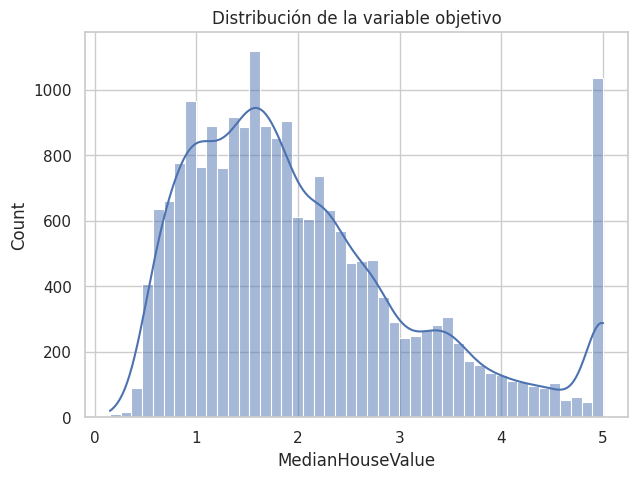

In [3]:
sns.histplot(y, kde=True)
plt.title("Distribución de la variable objetivo")
plt.show()


## 2. División del dataset en entrenamiento y test

Usamos:
- 80% entrenamiento
- 20% test

La regresión NO requiere estratificación.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((16512, 8), (4128, 8))

## 3. Estandarización

Muchos modelos de regresión son sensibles a la escala:

- SVR
- kNN Regressor
- Regresiones lineales penalizadas (Ridge, Lasso)

Compararemos:
- StandardScaler
- MinMaxScaler
- RobustScaler


In [5]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
}

scaled_versions = {}

for name, scaler in scalers.items():
    scaler.fit(X_train)
    scaled_versions[name] = (
        scaler.transform(X_train),
        scaler.transform(X_test)
    )


## 4. Modelos clásicos de regresión

Evaluaremos:

- **Linear Regression**  
- **Ridge Regression**  
- **Lasso Regression**  
- **SVR (kernel lineal y RBF)**  
- **kNN Regressor**  
- **Random Forest Regressor**  
- **Gradient Boosting Regressor**


In [6]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, random_state=42),
    "SVR Linear": SVR(kernel="linear", C=1.0),
    "SVR RBF": SVR(kernel="rbf", C=10.0, gamma=0.1),
    "kNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for model_name, model in models.items():
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="r2")
    results[model_name] = scores
    print(f"{model_name}: R2 = {scores.mean():.4f} ± {scores.std():.4f}")


Linear Regression: R2 = 0.6115 ± 0.0124
Ridge: R2 = 0.6115 ± 0.0124
Lasso: R2 = 0.6115 ± 0.0123
SVR Linear: R2 = -0.9698 ± 2.4332
SVR RBF: R2 = 0.7532 ± 0.0103
kNN Regressor: R2 = 0.6819 ± 0.0080
Random Forest: R2 = 0.8056 ± 0.0064
Gradient Boosting: R2 = 0.7881 ± 0.0068


## 5. Comparación visual de modelos


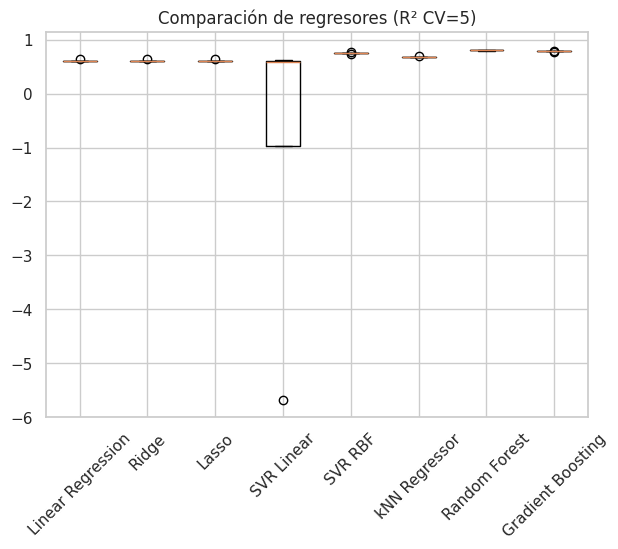

In [8]:
plt.boxplot(results.values(), labels=results.keys())
plt.title("Comparación de regresores (R² CV=5)")
plt.xticks(rotation=45)
plt.show()


## 6. Selección y entrenamiento final del mejor modelo

Por desempeño y robustez, usamos **Random Forest Regressor**.


In [9]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


## 7. Métricas de evaluación en regresión

Evaluaremos:
- MSE
- RMSE
- MAE
- R²


In [10]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


MSE:  0.2552
RMSE: 0.5051
MAE:  0.3274
R²:   0.8053


- Gráfico predicciones vs reales

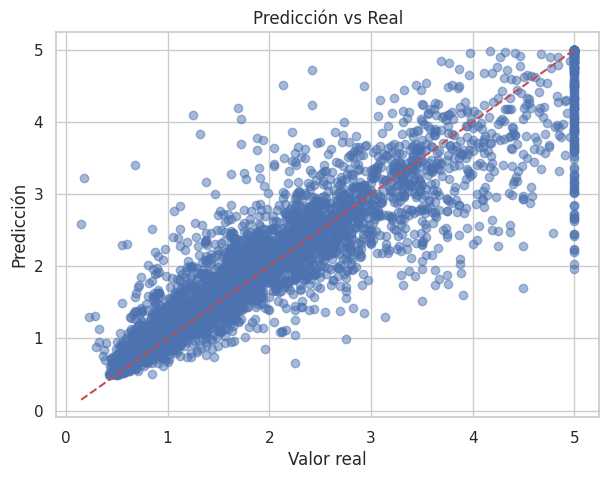

In [11]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Real")
plt.show()


## 8. Interpretación de modelos

Los modelos basados en árboles permiten obtener **importancia de características**.


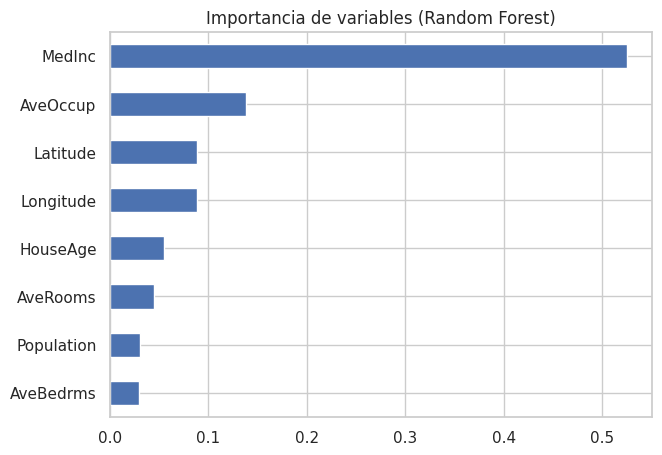

In [13]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh")
plt.title("Importancia de variables (Random Forest)")
plt.show()


## 9. Optimización de hiperparámetros

Alternativas:
- GridSearchCV
- RandomizedSearchCV
- HalvingGridSearchCV


In [14]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 4, 6]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor MSE:", -grid.best_score_)


Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Mejor MSE: 0.25985262125315156


## 10. Uso del modelo para predicciones nuevas


In [15]:
nuevo = X_test.iloc[[0]]
print("Nuevo dato:", nuevo)

nuevo_scaled = scaler.transform(nuevo)
pred = model.predict(nuevo_scaled)

print("Predicción:", pred)


Nuevo dato:        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
20046  1.6812      25.0  4.192201   1.022284      1392.0  3.877437     36.06   

       Longitude  
20046    -119.01  
Predicción: [0.5095]


# Conclusiones

En este notebook cubrimos:

- División, escalado y preparación de datos para regresión.
- Entrenamiento y comparación de regresores clásicos.
- Evaluación con métricas apropiadas (MSE, RMSE, MAE, R²).
- Optimización de hiperparámetros.
- Interpretación del modelo (importancia de features).
- Predicción en nuevos datos.

Este flujo representa un pipeline completo y profesional de regresión en ML.
